In [4]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
from sklearn.model_selection import GridSearchCV
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

# Distributed Denial-of-Service Risk Prediction

# Data Generation

In [5]:
columns = ['Industry', 'Region', 'Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
INDUSTRIES = ['AUTOMOTIVE', 'HEALTHCARE', 'ECOMMERCE', 'TELECOM', 'FINANCIAL SERVICES', 'EDUCATION', 'OTHER']
REGIONS = ['EUROPE', 'NORTH AMERICA', 'SOUTH AMERICA', 'AFRICA', 'ASIA']
INDUSTRY_TO_RISK = {
    'AUTOMOTIVE': 0.1,
    'HEALTHCARE': 0.4,
    'ECOMMERCE': 0.3,
    'TELECOM': 0.4,
    'FINANCIAL SERVICES': 0.5,
    'EDUCATION': 0.1,
    'OTHER': 0.25
}

REGION_TO_RISK = {
    'EUROPE': 0.4,
    'NORTH AMERICA': 0.5,
    'SOUTH AMERICA': 0.5,
    'AFRICA': 0.2,
    'ASIA': 0.3
}

ADVISOR = ['NO', 'YES']
LEVELS = ['LOW', 'MEDIUM', 'HIGH']

In [12]:
def generate_data(nr_entries = 1000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in tqdm(range(0, nr_entries)):
        
        region = random.choice(REGIONS)
        industry = random.choice(INDUSTRIES)
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = random.choice(ADVISOR)
        
        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = (invested_perc / max_invested_perc) + ADVISOR.index(external_adv) + 1 - (succ_attack / nr_attacks) - (known_vulnerabilities / max_nr_vulnerabilities) - INDUSTRY_TO_RISK[industry] - REGION_TO_RISK[region]

        df.loc[i] = [industry, region, invested_amount, succ_attack, failed_attack, business_value, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, upper_boundary = 1.0, lower_boundary = 0.0):
  if weighted_risk >= upper_boundary:
      return "LOW"
  elif weighted_risk >= lower_boundary and weighted_risk < upper_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [17]:
data = generate_data(nr_entries = 100000)
#data = pd.read_csv('./ddos_data.csv')
#data.pop('Unnamed: 0')

100%|██████████| 100000/100000 [11:42<00:00, 142.44it/s]


In [16]:
data.head()

,Industry,Region,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Known Vulnerabilities,External Advisor,Risk
0,ECOMMERCE,SOUTH AMERICA,219837,3,43,5015966,3,NO,HIGH
1,HEALTHCARE,EUROPE,98530,38,14,5072906,3,NO,HIGH
2,EDUCATION,SOUTH AMERICA,1464092,19,47,4912120,4,NO,MEDIUM
3,HEALTHCARE,EUROPE,83603,13,21,4913510,0,NO,HIGH
4,TELECOM,ASIA,616254,24,41,4997121,8,YES,MEDIUM


In [10]:
data.describe()

,Industry,Region,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Known Vulnerabilities,External Advisor,Risk
count,100,100,100,100,100,100,100,100,100
unique,7,5,100,42,44,100,10,2,3
top,AUTOMOTIVE,ASIA,1348099,0,46,4950275,0,YES,HIGH
freq,21,27,1,6,6,1,13,61,66


### Data Export as .csv

In [18]:
data.to_csv('ddos_data.csv')

## Data Processing

### Categorization Step

In [19]:
start = time.time()

levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }
industry_mapping = {
    'AUTOMOTIVE': 0,
    'HEALTHCARE': 1,
    'ECOMMERCE': 2,
    'TELECOM': 3,
    'FINANCIAL SERVICES': 4,
    'EDUCATION': 5,
    'OTHER': 6
}

region_mapping = {
    'EUROPE': 0,
    'NORTH AMERICA': 1,
    'SOUTH AMERICA': 2,
    'AFRICA': 3,
    'ASIA': 4
}

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping, 'Industry': industry_mapping, 'Region': region_mapping})

stop = time.time()
print(f"Categorization time: {stop - start}s")

Categorization time: 0.13004016876220703s


In [20]:
data.head()

,Industry,Region,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Known Vulnerabilities,External Advisor,Risk
0,6,0,504761,35,38,4978245,1,0,2
1,2,4,831405,40,18,5088046,5,1,1
2,5,1,90463,18,19,5036064,3,1,1
3,2,4,873859,49,43,5035998,3,1,1
4,6,0,79171,30,33,4967984,2,0,2


### Normalization Step - using scaler

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used for the scikit models
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalized Data
X = data[features]
Y = data["Risk"]
X_normalized = scaler.transform(data[features])


# Normalized Splitted Data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [36]:
dump(scaler, SCALER_OUTPUT_PATH + 'MinMaxScaler_ddos.joblib') 

['../src/scaler/MinMaxScaler_ddos.joblib']

In [37]:
scaler.scale_

array([1.66666667e-01, 2.50000000e-01, 6.52484269e-07, 2.04081633e-02,
       2.04081633e-02, 2.12422917e-06, 1.11111111e-01, 1.00000000e+00])

# Multilayer Perceptron (MLP) using Backpropagation

In [24]:
from sklearn.neural_network import MLPClassifier

In [25]:
mlp = MLPClassifier(max_iter=100000)

In [26]:
start = time.time()

mlp_params = {
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(5, 5)],
'solver': ["lbfgs", "sgd", "adam"],
'activation': ["logistic", "relu", "tanh"]
}

# Instanciate the Grid for parameter tuning
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy', n_jobs=-1)

mlp = mlp_grid.fit(X_train_normalized, y_train)


stop = time.time()
print(f"Build time: {stop - start}s")

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [27]:
print(mlp.best_estimator_)
print(mlp.best_params_)
print('Best Accuracy: {0:.2%}'.format(mlp.best_score_))

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5),
              learning_rate='invscaling', max_iter=100000, solver='lbfgs')
{'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
Best Accuracy: 93.93%


## Prediction

In [35]:
prediction_result_mapping = {0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

predicted_risk = mlp.predict(scaler.transform([[1, 0, 1077113, 8, 29, 4947796, 6, 1]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


## Evaluate

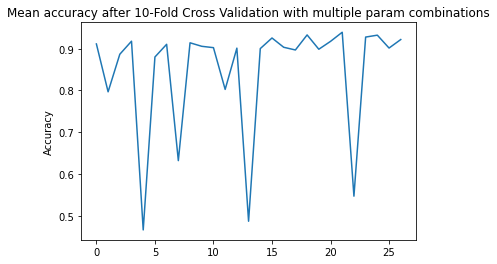

In [38]:
test_scores = mlp.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation with multiple param combinations")
plt.plot(test_scores)
plt.ylabel("Accuracy")
plt.show()

In [39]:
accuracy = mlp.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 95.06%


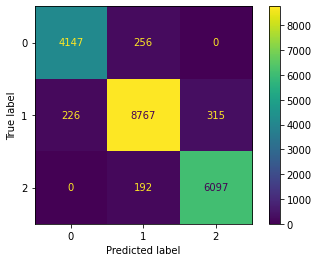

In [40]:
plot_confusion_matrix(mlp, X_test_normalized, y_test)  
plt.show()

## Export

In [41]:
dump(mlp, MODEL_OUTPUT_PATH + 'MLP_ddos_classifier.joblib') 

['../src/models/MLP_ddos_classifier.joblib']